## Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install dependencies

In [2]:
!pip install pythainlp   rouge-score nltk deepcut optuna gradio -q
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
!ls


import nltk
nltk.download('punkt')
nltk.download('wordnet')


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 24.4 MB/s eta 0:00:00
drive  sample_data  thsarabunnew-webfont.ttf


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## CNN encoder

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNNEncoder(nn.Module):
    def __init__(self, backbone_name="resnet50", pretrained=True, weight_path=None, map_location=None):
        super().__init__()
        backbone = getattr(models, backbone_name)(pretrained=pretrained)
        # Initial layers: Conv1, BN, ReLU, MaxPool
        self.conv1 = backbone.conv1
        self.bn1 = backbone.bn1
        self.relu = backbone.relu
        self.maxpool = backbone.maxpool
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4

        # Load weights from custom path
        if weight_path is not None:
            state = torch.load(weight_path, map_location=map_location)
            # ถ้า save state dict แบบ model.state_dict()
            if 'state_dict' in state:
                # รองรับ checkpoint บางแบบ เช่น {'state_dict': ...}
                state = state['state_dict']
            self.load_state_dict(state, strict=False)  # strict=False ในกรณีที่ layer ไม่ตรงเป๊ะ
            print(f"Loaded CNN weights from {weight_path}")

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

### test CNN Encoder

In [4]:
import torch

# ใส่ path ไฟล์ weights (หรือ None ถ้าไม่โหลด custom weight)
weight_path = "/content/drive/MyDrive/Final_Deep_project/RestNet50/best_resnet50_model_20250608_123252.pth"  # เปลี่ยนเป็น path จริง ถ้ามี

# สร้าง encoder (โหลด weights ถ้าระบุ)
encoder = CNNEncoder("resnet50", pretrained=False, weight_path=weight_path, map_location='cpu')

# ทดสอบ forward
dummy_input = torch.randn(2, 3, 224, 224)  # batch_size=2, RGB, 224x224
Fc = encoder(dummy_input)
# assert ตรวจสอบ shape
expected_shape = (2, 2048, 7, 7)  # สำหรับ resnet50
assert Fc.shape == expected_shape, f"Expected {expected_shape}, got {Fc.shape}"

print("Test passed: Feature shape is correct.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded CNN weights from /content/drive/MyDrive/Final_Deep_project/RestNet50/best_resnet50_model_20250608_123252.pth
Test passed: Feature shape is correct.


## FasterRCNNBackbone

In [5]:
import torch
import torch.nn as nn
import torchvision
from torchvision.ops import roi_align
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
class FasterRCNNBackbone(nn.Module):
    def __init__(self, num_classes, pretrained_path=None, out_size=14, map_location='cpu'):
        super().__init__()
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        if pretrained_path is not None:
            state = torch.load(pretrained_path, map_location=map_location)
            try:
                self.model.load_state_dict(state)
                print(f"Loaded FasterRCNN weights from {pretrained_path}")   # <-- เพิ่มตรงนี้
            except Exception as e:
                raise RuntimeError(f"Cannot load state dict: {e}")
        self.backbone = self.model.backbone
        self.out_channels = self.backbone.out_channels
        self.out_size = out_size
        self.feature_adj = nn.Sequential(
            nn.Conv2d(self.out_channels, 256, kernel_size=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, boxes=None, detect=False):
        if detect:
            if isinstance(x, torch.Tensor):
                x = [img for img in x]
            return self.model(x)
        else:
            features = self.backbone(x)['0']  # (B, 256, H, W)
            B = features.shape[0]
            device = features.device
            if boxes is None:
                H, W = features.shape[2], features.shape[3]
                boxes = [torch.tensor([[0, 0, W-1, H-1]], dtype=torch.float, device=device) for _ in range(B)]
                boxes = torch.cat([
                    torch.cat([torch.full((1, 1), i, device=device), b], dim=1)
                    for i, b in enumerate(boxes)
                ], dim=0)
            roi_features = roi_align(features, boxes, output_size=(self.out_size, self.out_size))
            roi_features = self.feature_adj(roi_features)
            return roi_features

### test FasterRCNNBackbone

In [6]:
# Example usage:
num_classes = 4  # background + bridge_damage (แก้ตาม dataset)
pretrained_path = "/content/drive/MyDrive/Final_Deep_project/FasterRCNN/fasterrcnn_trained.pth"
faster_rcnn_encoder = FasterRCNNBackbone(num_classes, pretrained_path=pretrained_path, map_location='cpu')
dummy_input = torch.randn(2, 3, 224, 224)
Ff = faster_rcnn_encoder(dummy_input)
# สมมติขนาด output ที่คาดหวัง เช่น (2, 256, 56, 56) ขึ้นกับ backbone
assert Ff.shape[0] == 2 and Ff.shape[1] == 256, f"Unexpected shape: {Ff.shape}"

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 209MB/s]


Loaded FasterRCNN weights from /content/drive/MyDrive/Final_Deep_project/FasterRCNN/fasterrcnn_trained.pth


## FeatureFusion

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeatureFusion(nn.Module):
    def __init__(self, in_cnn, in_frcnn, in_vit, out_c=512, reduction=16):
        """
        in_cnn: channels of CNN feature map (Fc)
        in_frcnn: channels of Faster R-CNN feature map (Ff)
        in_vit: channels of ViT feature map (Fv)
        out_c: common channel dimension after adjustment
        reduction: for bottleneck in attention mechanism
        """
        super().__init__()
        self.adj_conv_cnn = nn.Conv2d(in_cnn, out_c, kernel_size=1)
        self.adj_conv_frcnn = nn.Conv2d(in_frcnn, out_c, kernel_size=1)
        self.adj_conv_vit = nn.Conv2d(in_vit, out_c, kernel_size=1)

        self.pw_conv1 = nn.Conv2d(3*out_c, 3*out_c // reduction, kernel_size=1)
        self.pw_conv2 = nn.Conv2d(3*out_c // reduction, 3*out_c, kernel_size=1)

    def forward(self, Fc, Ff, Fv):
        """
        Fc: (B, in_cnn, H, W)  -- CNN feature
        Ff: (B, in_frcnn, H, W) -- Faster R-CNN feature
        Fv: (B, in_vit, 1, 1)   -- ViT feature (หรือ (B, in_vit, H, W) ก็ได้)
        Returns: (B, 3*out_c, H, W) fused features (weighted)
        """
        # 1. ปรับขนาด channel ให้เท่ากัน
        Fc_adj = self.adj_conv_cnn(Fc)     # (B, out_c, H, W)
        Ff_adj = self.adj_conv_frcnn(Ff)   # (B, out_c, H, W)
        Fv_adj = self.adj_conv_vit(Fv)     # (B, out_c, 1, 1) (อาจจะเป็น (B, out_c, H, W) ก็ได้)

        # 2. ถ้า Fv เป็น (B, out_c, 1, 1) —> upsample ให้เท่ากับ (H, W)
        H, W = Fc_adj.shape[2], Fc_adj.shape[3]
        if Fv_adj.shape[2:] != (H, W):
            Fv_adj = F.interpolate(Fv_adj, size=(H, W), mode='nearest')

        # 3. concat along channel
        F_concat = torch.cat([Fc_adj, Ff_adj, Fv_adj], dim=1)  # (B, 3*out_c, H, W)

        # 4. Channel Attention (Squeeze-and-Excitation)
        FGAP = F.adaptive_avg_pool2d(F_concat, (1, 1))
        Fpw1 = F.relu(self.pw_conv1(FGAP))
        Fpw2 = torch.sigmoid(self.pw_conv2(Fpw1))
        F_weighted = F_concat * Fpw2
        return F_weighted



### test FeatureFusion

In [8]:

# Example usage:
# Suppose Fc is from CNN (B, 2048, 7, 7), Ff is from FPN of Faster R-CNN (B, 256, 7, 7)
# Set out_c=512 (หรือเลือกเท่าที่ต้องการ)
fusion = FeatureFusion(in_cnn=2048, in_frcnn=256, in_vit=768, out_c=512)
Fc = torch.randn(2, 2048, 7, 7)   # ResNet
Ff = torch.randn(2, 256, 7, 7)    # Faster R-CNN
Fv = torch.randn(2, 768, 1, 1)    # ViT (B, 768, 1, 1)
F_fused = fusion(Fc, Ff, Fv)
print("Fused feature shape:", F_fused.shape)  # (2, 1536, 7, 7)


Fused feature shape: torch.Size([2, 1536, 7, 7])


## FeatureFusionWithRecalibration

In [9]:
class FeatureFusionWithRecalibration(nn.Module):
    def __init__(self, in_cnn, in_frcnn, out_c=512, reduction=16):
        super().__init__()
        self.adj_conv_cnn = nn.Conv2d(in_cnn, out_c, kernel_size=1)
        self.adj_conv_frcnn = nn.Conv2d(in_frcnn, out_c, kernel_size=1)

        self.pw_conv1 = nn.Conv2d(2*out_c, 2*out_c // reduction, kernel_size=1)
        self.pw_conv2 = nn.Conv2d(2*out_c // reduction, 2*out_c, kernel_size=1)

    def forward(self, Fc, Ff):
        # Adjust channels
        Fc_adj = self.adj_conv_cnn(Fc)      # (B, C, H, W)
        Ff_adj = self.adj_conv_frcnn(Ff)    # (B, C, H, W)

        # Resize spatial dim if needed
        H, W = Fc_adj.shape[2:]
        if Ff_adj.shape[2:] != (H, W):
            Ff_adj = F.interpolate(Ff_adj, size=(H, W), mode='bilinear', align_corners=False)

        # Concat
        F_concat = torch.cat([Fc_adj, Ff_adj], dim=1)    # (B, 2C, H, W)

        # Squeeze & Excitation (channel attention)
        FGAP = F.adaptive_avg_pool2d(F_concat, (1, 1))   # (B, 2C, 1, 1)
        Fpw1 = F.relu(self.pw_conv1(FGAP))               # (B, 2C//r, 1, 1)
        Fpw2 = torch.sigmoid(self.pw_conv2(Fpw1))        # (B, 2C, 1, 1)
        wc, wf = torch.chunk(Fpw2, 2, dim=1)             # (B, C, 1, 1) x2

        # Recalibrate
        Fc_recal = Fc_adj * wc
        Ff_recal = Ff_adj * wf

        # Fusion (คุณสามารถปรับสูตรตามต้องการ)
        Ffinal_c = Fc_adj + Ff_recal
        Ffinal_f = Ff_adj + Fc_recal

        Ffinal = torch.cat([Ffinal_c, Ffinal_f], dim=1)  # (B, 2C, H, W)
        return Ffinal


### test FeatureFusionWithRecalibration

In [10]:
# Example usage:
module = FeatureFusionWithRecalibration(in_cnn=2048, in_frcnn=256, out_c=512)
Fc = torch.randn(2, 2048, 7, 7)
Ff = torch.randn(2, 256, 7, 7)
Ffinal = module(Fc, Ff)
print("Output shape:", Ffinal.shape)  # (2, 1536, 7, 7)

Output shape: torch.Size([2, 1024, 7, 7])


## CorrelationAwareAttention

In [11]:
class CorrelationAwareAttention(nn.Module):
    def __init__(self, feat_dim, hidden_dim, embed_dim, num_sources=2):
        super().__init__()
        # Embedding layer for Ffinal (ลด channel)
        self.embedding = nn.Conv2d(feat_dim, embed_dim, kernel_size=1)
        # Attention transforms
        self.W_e = nn.Linear(embed_dim, hidden_dim)
        self.W_h = nn.Linear(hidden_dim, hidden_dim)
        self.w_a = nn.Linear(hidden_dim, 1, bias=False)
        self.num_sources = num_sources

    def forward(self, Ffinal, Fc_adj, Ff_adj, h_t):
        # Ffinal: (B, 2C, H, W)
        # Fc_adj, Ff_adj: (B, C, H, W)
        # h_t: (B, hidden_dim)

        # 1) Embedding multi-level feature
        Eemb = self.embedding(Ffinal)  # (B, embed_dim, H, W)
        B, E, H, W = Eemb.shape
        N = H * W

        # Resize spatial if needed
        if Fc_adj.shape[2:] != Ff_adj.shape[2:]:
            Ff_adj = F.interpolate(Ff_adj, size=Fc_adj.shape[2:], mode='bilinear', align_corners=False)

        # Flatten spatial dims for attention computation
        Eemb_flat = Eemb.view(B, E, N).transpose(1, 2)  # (B, N, E)

        # 2) Correlation Matrix (แค่ CNN <-> FRCNN)
        C = Fc_adj.shape[1]  # channel dim (should == out_c)
        Ec = Fc_adj.view(B, C, N).transpose(1, 2)  # (B, N, C)
        Ef = Ff_adj.view(B, C, N).transpose(1, 2)  # (B, N, C)

        Rc = torch.bmm(Ec, Ef.transpose(1, 2))  # (B, N, N)
        Rc_norm = torch.softmax(Rc, dim=-1)

        # 3) Traditional Attention Score
        Weei = self.W_e(Eemb_flat)                 # (B, N, hidden_dim)
        Whht = self.W_h(h_t).unsqueeze(1)          # (B, 1, hidden_dim)
        et = self.w_a(torch.tanh(Weei + Whht)).squeeze(-1)  # (B, N)

        # 4) Adjust attention by correlation
        e_corr_c = torch.bmm(Rc_norm, et.unsqueeze(2)).squeeze(-1)  # (B, N)
        st = et + e_corr_c                                          # (B, N)
        alpha = torch.softmax(st, dim=1)                            # (B, N)

        # 5) Weighted sum for context vector
        zt = torch.bmm(alpha.unsqueeze(1), Eemb_flat).squeeze(1)  # (B, embed_dim)

        return zt, alpha  # (B, embed_dim), (B, N)


### test CorrelationAwareAttention

In [12]:
B, C, H, W = 2, 512, 7, 7
embed_dim = 256
hidden_dim = 512
module = CorrelationAwareAttention(feat_dim=3*C, hidden_dim=hidden_dim, embed_dim=embed_dim)
Ffinal = torch.randn(B, 3*C, H, W)
Fc_adj = torch.randn(B, C, H, W)
Ff_adj = torch.randn(B, C, H, W)
h_t = torch.randn(B, hidden_dim)
zt, alpha = module(Ffinal, Fc_adj, Ff_adj, h_t)
print("zt:", zt.shape, "alpha:", alpha.shape)

zt: torch.Size([2, 256]) alpha: torch.Size([2, 49])


# Decoder

## LSTMDecoderCorrAttn

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LSTMDecoderCorrAttn(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size):
        super().__init__()
        self.word_embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTMCell(embed_dim + embed_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, zt, captions, states):
        # zt: (B, embed_dim)  context from attention
        batch_size, seq_len = captions.size()
        outputs = []
        h, c = states
        for t in range(seq_len):
            xt = self.word_embedding(captions[:, t])   # (B, embed_dim)
            lstm_input = torch.cat([xt, zt], dim=1)    # (B, 2*embed_dim)
            h, c = self.lstm(lstm_input, (h, c))       # h, c: (B, hidden_dim)
            out = self.fc(h)    # (B, vocab_size)
            outputs.append(out.unsqueeze(1))           # (B, 1, vocab_size)
        outputs = torch.cat(outputs, dim=1)            # (B, seq_len, vocab_size)
        return outputs, (h, c)                         # <=== สำคัญ!



## GRU

In [14]:
class GRUDecoderCorrAttn(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, num_sources=1):
        super().__init__()
        self.word_embedding = nn.Embedding(vocab_size, embed_dim)
        # ถ้า context มาจากหลาย source: zt size = num_sources * embed_dim
        self.gru = nn.GRUCell(embed_dim + num_sources*embed_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, zt, captions, h_t):
        """
        zt: (B, num_sources*embed_dim)
        captions: (B, seq_len)
        h_t: (B, hidden_dim)
        """
        outputs = []
        B, seq_len = captions.shape
        for t in range(seq_len):
            xt = self.word_embedding(captions[:, t])         # (B, embed_dim)
            gru_input = torch.cat([xt, zt], dim=1)           # (B, embed_dim + num_sources*embed_dim)
            h_t = self.gru(gru_input, h_t)                   # (B, hidden_dim)
            out = self.fc(h_t)                               # (B, vocab_size)
            outputs.append(out.unsqueeze(1))
        return torch.cat(outputs, dim=1), h_t  # (B, seq_len, vocab_size), (B, hidden_dim)


## Transformer

In [15]:
import torch.nn as nn
import numpy as np
class TransformerDecoderCorrAttn(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers=2, nhead=4, dim_feedforward=512, dropout=0.1):
        super().__init__()
        self.word_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # use [batch, seq, dim]
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, zt, captions):
        # รองรับ shape (seq_len,), (1, seq_len), (B, seq_len), (B, 1, seq_len)
        captions = captions.long()
        if captions.dim() == 1:
            captions = captions.unsqueeze(0)  # (1, seq_len)
        elif captions.dim() == 3:
            # เช่น (B, 1, seq_len)
            captions = captions.squeeze(1)
        # ตอนนี้ captions เป็น (B, seq_len)
        B, seq_len = captions.shape

        cap_emb = self.word_embedding(captions)         # (B, seq_len, embed_dim)
        cap_emb = self.pos_encoder(cap_emb)             # add pos encoding

        # ทำให้ zt เป็น (B, 1, embed_dim)
        if zt.dim() == 2:
            zt = zt.unsqueeze(1)  # (B, 1, embed_dim)

        out = self.transformer_decoder(
            cap_emb,             # tgt (B, seq_len, embed_dim)
            zt                   # memory (B, 1, embed_dim)
        )
        out = self.fc(out)  # (B, seq_len, vocab_size)
        return out



class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


# DKICNet

In [17]:
class DKICNet(nn.Module):
    def __init__(
        self,
        cnn_backbone="resnet50", cnn_pretrained=False,
        num_classes=4, out_c=512, reduction=16,
        embed_dim=256, hidden_dim=512, vocab_size=1000,
        severity_classes=4, cnn_pretrained_path=None,
        frcnn_pretrained_path=None,
        decoder_type="gru"
    ):
        super().__init__()
        self.decoder_type = decoder_type
        self.cnn_encoder = CNNEncoder(cnn_backbone, pretrained=cnn_pretrained, weight_path=cnn_pretrained_path)
        self.frcnn_encoder = FasterRCNNBackbone(num_classes=num_classes, pretrained_path=frcnn_pretrained_path)

        self.fusion = FeatureFusionWithRecalibration(
            in_cnn=2048, in_frcnn=256, out_c=out_c, reduction=reduction  # <-- ไม่มี in_vit
        )
        self.attn = CorrelationAwareAttention(
            feat_dim=2 * out_c, hidden_dim=hidden_dim, embed_dim=embed_dim  # <-- 2*out_c
        )

        if self.decoder_type == "gru":
            self.decoder = GRUDecoderCorrAttn(embed_dim=embed_dim, hidden_dim=hidden_dim, vocab_size=vocab_size)
        elif self.decoder_type == "lstm":
            self.decoder = LSTMDecoderCorrAttn(embed_dim=embed_dim, hidden_dim=hidden_dim, vocab_size=vocab_size)
        elif self.decoder_type == "transformer":
            self.decoder = TransformerDecoderCorrAttn(
                embed_dim=embed_dim, hidden_dim=hidden_dim, vocab_size=vocab_size,
                nhead=2, num_layers=1, dropout=0.25
            )
        else:
            raise ValueError(f"decoder_type '{decoder_type}' not supported")

        self.severity_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Linear(2 * out_c, 128), nn.ReLU(), nn.Linear(128, severity_classes)
        )
        self.bbox_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Linear(2 * out_c, 128), nn.ReLU(), nn.Linear(128, 4)
        )

    def forward(self, images, captions, states=None):
        Fc = self.cnn_encoder(images)
        Ff = self.frcnn_encoder(images)
        Ffinal = self.fusion(Fc, Ff)  # <-- ไม่มี Fv
        Fc_adj = self.fusion.adj_conv_cnn(Fc)
        Ff_adj = self.fusion.adj_conv_frcnn(Ff)
        B = images.size(0)
        hidden_dim = self.attn.W_h.in_features
        h_t = torch.zeros(B, hidden_dim, device=images.device)
        zt, alpha = self.attn(Ffinal, Fc_adj, Ff_adj, h_t)  # <-- ไม่มี Fv_adj
        if self.decoder_type == "gru":
            output, _ = self.decoder(zt, captions, h_t)
        elif self.decoder_type == "lstm":
            c_t = torch.zeros(B, hidden_dim, device=images.device)
            output, _ = self.decoder(zt, captions, (h_t, c_t))
        else:
            output = self.decoder(zt, captions)
        severity_logits = self.severity_head(Ffinal)
        bbox_pred = self.bbox_head(Ffinal)
        return output, alpha, severity_logits, bbox_pred

    def top_k_temperature_sampling(self, logits, top_k=1, temperature=1.0):
        logits = logits / temperature
        values, indices = torch.topk(logits, top_k)
        probs = torch.softmax(values, dim=-1)
        idx = torch.multinomial(probs, 1)
        next_token = indices[idx]
        return next_token.item()

    def generate(self, image, max_len=50, sos_token=2, eos_token=3, device='cuda', top_k=1, temperature=1.0, repetition_penalty=1.0):
        self.eval()
        with torch.no_grad():
            if image.dim() == 3:
                image = image.unsqueeze(0)
            image = image.to(device)

            Fc = self.cnn_encoder(image)
            Ff = self.frcnn_encoder(image)
            Ffinal = self.fusion(Fc, Ff)
            Fc_adj = self.fusion.adj_conv_cnn(Fc)
            Ff_adj = self.fusion.adj_conv_frcnn(Ff)
            hidden_dim = self.attn.W_h.in_features
            h_t = torch.zeros(1, hidden_dim, device=device)
            zt, _ = self.attn(Ffinal, Fc_adj, Ff_adj, h_t)

            severity_logits = self.severity_head(Ffinal)
            bbox_pred = self.bbox_head(Ffinal)
            severity_class = severity_logits.argmax(dim=1).item()
            bbox_pred = bbox_pred.squeeze(0).cpu().numpy().tolist()

            input_token = torch.tensor([sos_token], device=device).unsqueeze(0)
            outputs = []

            if self.decoder_type == "gru":
                dec_state = h_t
            elif self.decoder_type == "lstm":
                c_t = torch.zeros(1, hidden_dim, device=device)
                dec_state = (h_t, c_t)
            elif self.decoder_type == "transformer":
                memory = zt.unsqueeze(1)  # [1, 1, embed_dim]
                tgt_tokens = [sos_token]
            else:
                raise NotImplementedError("Decoder type not supported.")

            for step in range(max_len):
                if self.decoder_type in {"gru", "lstm"}:
                    xt = self.decoder.word_embedding(input_token).squeeze(1)
                    rnn_input = torch.cat([xt, zt], dim=1)
                    if self.decoder_type == "gru":
                        dec_state = self.decoder.gru(rnn_input, dec_state)
                        logits = self.decoder.fc(dec_state)[0]
                    else:
                        h, c = dec_state
                        h, c = self.decoder.lstm(rnn_input, (h, c))
                        dec_state = (h, c)
                        logits = self.decoder.fc(h)[0]
                elif self.decoder_type == "transformer":
                    tgt_seq = torch.tensor([tgt_tokens], device=device).long()
                    logits = self.decoder(zt, tgt_seq)  # [1, seq_len, vocab_size]
                    logits = logits[:, -1, :].squeeze(0)
                else:
                    raise NotImplementedError()

                # repetition_penalty
                if outputs:
                    logits = logits.clone()
                    for prev_token in set(outputs):
                        logits[prev_token] /= repetition_penalty

                next_token = self.top_k_temperature_sampling(logits, top_k=top_k, temperature=temperature)
                if next_token == eos_token:
                    break
                outputs.append(next_token)
                if self.decoder_type == "transformer":
                    tgt_tokens.append(next_token)
                else:
                    input_token = torch.tensor([[next_token]], device=logits.device)

            return outputs, severity_class, bbox_pred


### test DKCI with GRU

In [18]:
import torch

vocab_size = 10000
model = DKICNet(
    cnn_backbone="resnet50",
    num_classes=4,  # ต้องตรงกับตอน train frcnn
    vocab_size=vocab_size,
    severity_classes=4,
    cnn_pretrained_path="/content/drive/MyDrive/Final_Deep_project/RestNet50/best_resnet50_model_20250608_123252.pth",
    frcnn_pretrained_path="/content/drive/MyDrive/Final_Deep_project/FasterRCNN/fasterrcnn_trained.pth",
    decoder_type="gru",
)

# Dummy input
dummy_img = torch.randn(2, 3, 224, 224)
dummy_cap = torch.randint(0, vocab_size, (2, 10))

# Forward
output, alpha, severity_logits, bbox_pred = model(dummy_img, dummy_cap)

# --- Assertion Check ---
assert output.shape[0] == 2, "Batch size ไม่ตรง"
assert output.shape[1] == 10, "Sequence length ไม่ตรง"
assert output.shape[2] == vocab_size, "vocab size ไม่ตรง"
assert severity_logits.shape == (2, 4), "Severity logits shape ผิด"
assert bbox_pred.shape == (2, 4), "bbox_pred shape ผิด"

print("DKICNet ready! Forward pass OK.")



#---- test LSTM decodeer ----#
vocab_size = 10000
model = DKICNet(
    cnn_backbone="resnet50",
    num_classes=4,  # ต้องตรงกับตอน train frcnn
    vocab_size=vocab_size,
    severity_classes=4,
    cnn_pretrained_path="/content/drive/MyDrive/Final_Deep_project/RestNet50/best_resnet50_model_20250608_123252.pth",
    frcnn_pretrained_path="/content/drive/MyDrive/Final_Deep_project/FasterRCNN/fasterrcnn_trained.pth",
    decoder_type="lstm",  # <------ เปลี่ยนตรงนี้ ถ้าอยากลอง lstm
)

# Dummy input
dummy_img = torch.randn(2, 3, 224, 224)
dummy_cap = torch.randint(0, vocab_size, (2, 10))

# Forward
output, alpha, severity_logits, bbox_pred = model(dummy_img, dummy_cap)


# batch=2, seq_len=10
assert output.shape == (2, 10, vocab_size), f"Shape mismatch: {output.shape}"
assert output.shape[1] == 10, "Sequence length ไม่ตรง"
assert output.shape[2] == vocab_size, "vocab size ไม่ตรง"
assert severity_logits.shape == (2, 4), "Severity logits shape ผิด"
assert bbox_pred.shape == (2, 4), "bbox_pred shape ผิด"

print("DKICNet ready! Forward pass OK. Decoder type =", model.decoder_type)


import torch

#---- test Transformer decoder ----#
vocab_size = 10000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DKICNet(
    cnn_backbone="resnet50",
    num_classes=4,  # ต้องตรงกับตอน train frcnn
    vocab_size=vocab_size,
    severity_classes=4,
    cnn_pretrained_path="/content/drive/MyDrive/Final_Deep_project/RestNet50/best_resnet50_model_20250608_123252.pth",
    frcnn_pretrained_path="/content/drive/MyDrive/Final_Deep_project/FasterRCNN/fasterrcnn_trained.pth",
    decoder_type="transformer",   # <------ ใช้ transformer
)

# Dummy input (long!)
dummy_img = torch.randn(2, 3, 224, 224).to(device)
dummy_cap = torch.randint(0, vocab_size, (2, 10), dtype=torch.long).to(device)
model = model.to(device)

# Forward
output, alpha, severity_logits, bbox_pred = model(dummy_img, dummy_cap)

# batch=2, seq_len=10
assert output.shape == (2, 10, vocab_size), f"Shape mismatch: {output.shape}"
assert output.shape[1] == 10, "Sequence length ไม่ตรง"
assert output.shape[2] == vocab_size, "vocab size ไม่ตรง"
assert severity_logits.shape == (2, 4), "Severity logits shape ผิด"
assert bbox_pred.shape == (2, 4), "bbox_pred shape ผิด"

print("DKICNet ready! Forward pass OK. Decoder type =", model.decoder_type)



Loaded CNN weights from /content/drive/MyDrive/Final_Deep_project/RestNet50/best_resnet50_model_20250608_123252.pth
Loaded FasterRCNN weights from /content/drive/MyDrive/Final_Deep_project/FasterRCNN/fasterrcnn_trained.pth
DKICNet ready! Forward pass OK.
Loaded CNN weights from /content/drive/MyDrive/Final_Deep_project/RestNet50/best_resnet50_model_20250608_123252.pth
Loaded FasterRCNN weights from /content/drive/MyDrive/Final_Deep_project/FasterRCNN/fasterrcnn_trained.pth
DKICNet ready! Forward pass OK. Decoder type = lstm
Loaded CNN weights from /content/drive/MyDrive/Final_Deep_project/RestNet50/best_resnet50_model_20250608_123252.pth
Loaded FasterRCNN weights from /content/drive/MyDrive/Final_Deep_project/FasterRCNN/fasterrcnn_trained.pth
DKICNet ready! Forward pass OK. Decoder type = transformer


# Data loader

In [19]:
from pythainlp.tokenize import word_tokenize
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import json
from pythainlp.tokenize import word_tokenize
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import json
# 1. สร้าง vocab จาก caption ทั้งหมด
def build_vocab(jsonl_path, min_freq=0):
    from collections import Counter
    counter = Counter()
    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in f:
            obj = json.loads(line)
            if obj.get('caption'):
                tokens = word_tokenize(obj['caption'], keep_whitespace=False)
                counter.update(tokens)
    # สร้าง vocab: padding=0, unk=1, sos=2, eos=3, (แล้วตามด้วย word)
    vocab = {'<pad>':0, '<unk>':1, '<sos>':2, '<eos>':3}

    for w, c in counter.items():

        if c >= min_freq and w not in vocab:
            vocab[w] = len(vocab)

    return vocab


class JSONLDataset(Dataset):
    def __init__(self, jsonl_path, vocab, max_len=2000, transform=None):
        self.records = []
        with open(jsonl_path, 'r', encoding='utf-8') as f:
            for line in f:
                obj = json.loads(line)
                # ใช้ 'caption' หรือ 'caption_thai' ก็ได้
                if obj.get('caption') or obj.get('caption_thai'):
                    self.records.append(obj)
        self.vocab = vocab
        self.max_len = max_len
        self.transform = transform or transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.records)

    def encode_caption(self, caption):
        tokens = word_tokenize(caption, keep_whitespace=False)
        ids = [self.vocab.get('<sos>', 2)]
        for w in tokens:
            ids.append(self.vocab.get(w, self.vocab['<unk>']))
        ids.append(self.vocab.get('<eos>', 3))
        if len(ids) < self.max_len:
            ids += [self.vocab['<pad>']] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]
        return torch.tensor(ids, dtype=torch.long)

    def __getitem__(self, idx):
        rec = self.records[idx]
        img = Image.open(rec['image']).convert('RGB')
        img_t = self.transform(img)
        caption_ids = self.encode_caption(rec['caption'])
        severity = torch.tensor(rec.get('severity', 0), dtype=torch.long)
        bndbox = rec.get("bndbox", None)
        if bndbox is not None:
            bndbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
            bndbox = torch.tensor(bndbox, dtype=torch.float)
        else:
            bndbox = torch.zeros(4, dtype=torch.float)
        return img_t, caption_ids, severity, bndbox



## load data

In [ ]:
# 3. สร้าง vocab & dataset & dataloader
jsonl_path = "./train/train.bbox224-2.jsonl"
vocab = build_vocab(jsonl_path)

dataset = JSONLDataset(jsonl_path, vocab, max_len=100)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=12,pin_memory=True)

# load val data set
val_jsonl_path = "./train/val.bbox224-2.jsonl"

val_dataset = JSONLDataset(val_jsonl_path, vocab, max_len=100)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=12,pin_memory=True)


# Training

## helper function

In [21]:

# NLP metric import...
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from pythainlp.tokenize import word_tokenize

rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
# ---- Bounding box metric ----
def box_iou(box1, box2):
    # box1, box2 : array หรือ tensor shape [4] = (x1, y1, x2, y2)
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(0, box1[2] - box1[0]) * max(0, box1[3] - box1[1])
    boxBArea = max(0, box2[2] - box2[0]) * max(0, box2[3] - box2[1])

    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou


def bbox_metrics(all_pred_bbox, all_gt_bbox):
    ious = []
    ap_05s = []
    N = all_pred_bbox.size(0)
    for i in range(N):
        pred = all_pred_bbox[i].cpu().numpy()
        gt = all_gt_bbox[i].cpu().numpy()
        iou = box_iou(pred, gt)     # ของคุณเอง
        ap_05 = 1.0 if iou > 0.5 else 0.0
        ious.append(iou)
        ap_05s.append(ap_05)
    return np.mean(ious), np.mean(ap_05s)




# ---- NLP METRIC ON VALIDATION SET (after train) ----
def decode_caption(cap_ids, inv_vocab_dict, min_length=16):
    cap_str = "".join([inv_vocab_dict.get(idx, '<unk>') for idx in cap_ids])
    tokens = word_tokenize(cap_str, engine="newmm")   # ลองเปลี่ยนเป็น deepcut หรือ attacut
    clean = []
    for i, w in enumerate(tokens):
        if w == '<eos>' and i < min_length: continue
        if w == '<eos>': break
        if w not in {'<pad>', '<sos>'}: clean.append(w)
    return clean
def compute_bleu(preds, refs, inv_vocab_dict):
    scores = []
    for pred, ref in zip(preds, refs):
        pred_tokens = decode_caption(pred, inv_vocab_dict)
        ref_tokens  = decode_caption(ref, inv_vocab_dict)
        if len(pred_tokens) == 0 or len(ref_tokens) == 0: continue
        score = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=SmoothingFunction().method1, weights=(0.5, 0.5, 0, 0))
        scores.append(score)
    return np.mean(scores) if scores else 0

def compute_rouge(preds, refs, inv_vocab_dict):
    r1, r2, rL = [], [], []
    for pred, ref in zip(preds, refs):
        pred_tokens = " ".join(decode_caption(pred, inv_vocab_dict))
        ref_tokens  = " ".join(decode_caption(ref, inv_vocab_dict))
        if len(pred_tokens) == 0 or len(ref_tokens) == 0: continue
        scores = rouge.score(ref_tokens, pred_tokens)
        r1.append(scores['rouge1'].fmeasure)
        r2.append(scores['rouge2'].fmeasure)
        rL.append(scores['rougeL'].fmeasure)
    return (np.mean(r1) if r1 else 0, np.mean(r2) if r2 else 0, np.mean(rL) if rL else 0)

def compute_meteor(preds, refs, inv_vocab_dict):
    meteor_scores = []
    for pred, ref in zip(preds, refs):
        pred_tokens = decode_caption(pred, inv_vocab_dict)
        ref_tokens  = decode_caption(ref, inv_vocab_dict)
        if len(pred_tokens) == 0 or len(ref_tokens) == 0: continue
        meteor_scores.append(meteor_score([ref_tokens], pred_tokens))
    return np.mean(meteor_scores) if meteor_scores else 0

# ---- Main: Validate Auto-Regressive ----
def validate_auto_regressive(model, val_loader, inv_vocab_dict, device, max_len=50):
    model.eval()
    all_preds, all_refs = [], []
    with torch.no_grad():
        for images, captions, *_ in val_loader:
            images = images.to(device)
            captions = captions.to(device)
            batch_size = images.size(0)
            for i in range(batch_size):
                pred_ids, _, _ =  model.generate (
              images[i], max_len=50, device=device, top_k=1, temperature=1,
          )
                ref_ids = captions[i].cpu().tolist()
                all_preds.append(pred_ids)
                all_refs.append(ref_ids)
    return all_preds, all_refs

def get_tf_prob(epoch):
    if epoch >= ss_epochs:
        return end_prob
    return start_prob - (start_prob - end_prob) * (epoch / ss_epochs)

## Train with NLP every 10 loop

Save model path: /content/drive/MyDrive/Final_Deep_project/experiment_log_novit_GM/GRU/bestmodel_20250614_061634.pth
Metrics log path: /content/drive/MyDrive/Final_Deep_project/experiment_log_novit_GM/GRU/metrics_log_20250614_061634.csv
Device: cuda
vocab size: 265


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded CNN weights from /content/drive/MyDrive/Final_Deep_project/RestNet50/best_resnet50_model_20250608_123252.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded FasterRCNN weights from /content/drive/MyDrive/Final_Deep_project/FasterRCNN/fasterrcnn_trained.pth

[Epoch 1] Teacher forcing prob: 1.00
Epoch 1 | train_loss: 11.0200 | loss_caption: 1.185 | loss_severity: 0.910 | loss_bbox: 0.009
Epoch 1 | train_loss: 11.0200 | val_loss: 19.6206 | SeverityAcc: 0.7889 | IOU: 0.3680 | AP@0.5: 0.2389
Saved best model at epoch 1: /content/drive/MyDrive/Final_Deep_project/experiment_log_novit_GM/GRU/bestmodel_20250614_061634.pth

[Epoch 2] Teacher forcing prob: 0.90
Epoch 2 | train_loss: 5.1741 | loss_caption: 1.193 | loss_severity: 0.055 | loss_bbox: 0.016
Epoch 2 | train_loss: 5.1741 | val_loss: 22.6883 | SeverityAcc: 0.8389 | IOU: 0.4341 | AP@0.5: 0.3556
No improvement for 1 epochs.

[Epoch 3] Teacher forcing prob: 0.80
Epoch 3 | train_loss: 4.5256 | loss_caption: 1.508 | loss_severity: 0.011 | loss_bbox: 0.011
Epoch 3 | train_loss: 4.5256 | val_loss: 23.6766 | SeverityAcc: 0.8222 | IOU: 0.4639 | AP@0.5: 0.4278
No improvement for 2 epochs.

[Epo

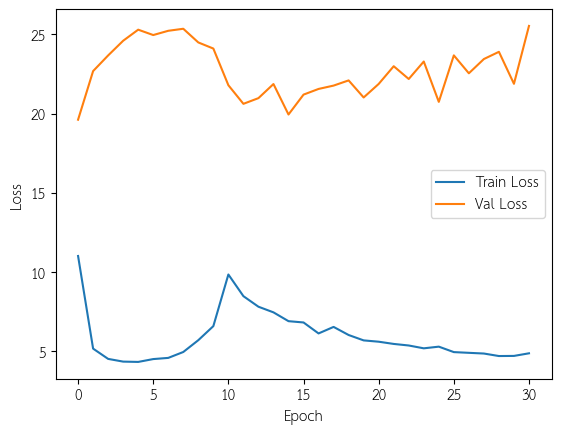

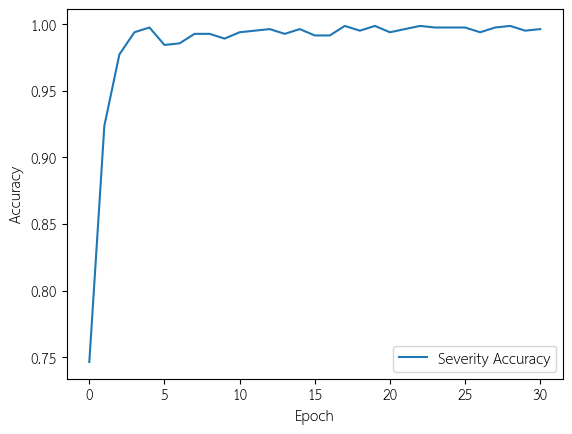

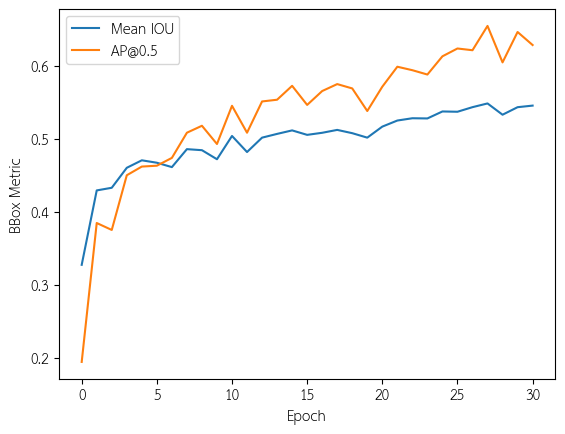

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import random, numpy as np, csv, os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd


# ---- FIX RANDOM SEED ----
seed = 314
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# ---- CONFIG ----
batch_size = 256         # ปรับลดเพื่อให้ train/stable ขึ้น
num_workers = 12
num_epochs = 300
patience = 30
pad_token = vocab['<pad>']
dropout = 0.5
encoder_lr = 0.0000241722049458957
decoder_lr =  0.00176746711386226

# ---- HYPERPARAM LOSS WEIGHT ----
alpha = 3.84663031888853   # caption
beta  = 1.36764237545158  # severity
gamma = 0.625734096283357 # bbox

# scheduled sampling
start_prob = 1.0
end_prob = 0.0
ss_epochs = 10
#--- decoder -----#
decoder_type="lstm"






#-------  PARAMETER  -------#

# label smoothing
criterion_caption = nn.CrossEntropyLoss(ignore_index=pad_token, label_smoothing=0.1)
criterion_severity = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()

now = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = f"/content/drive/MyDrive/Final_Deep_project/experiment_log_novit_GM/GRU/bestmodel_{now}.pth"
csv_path  = f"/content/drive/MyDrive/Final_Deep_project/experiment_log_novit_GM/GRU/metrics_log_{now}.csv"
param_path = f"/content/drive/MyDrive/Final_Deep_project/experiment_log_novit_GM/GRU/params_{now}.txt"

print(f"Save model path: {save_path}")
print(f"Metrics log path: {csv_path}")

with open(param_path, 'w', encoding='utf-8') as f:
    f.write(f"dropout: {dropout}\n")
    f.write(f"encoder_lr: {encoder_lr}\n")
    f.write(f"decoder_lr: {decoder_lr}\n")
    f.write(f"patience: {patience}\n")
    f.write(f"batch_size: {batch_size}\n")
    f.write(f"num_workers: {num_workers}\n")
    f.write(f"seed: {seed}\n")
    f.write(f"timestamp: {now}\n")

inv_vocab_dict = {idx: word for word, idx in vocab.items()}


# ---- SETUP DEVICE ----
try:
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
except ImportError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

print(f"vocab size: {len(vocab)}")

model = DKICNet(
    vocab_size=len(vocab),
    severity_classes=4,
    cnn_backbone="resnet50",
    cnn_pretrained=False,
    num_classes=4,
    cnn_pretrained_path="/content/drive/MyDrive/Final_Deep_project/RestNet50/best_resnet50_model_20250608_123252.pth",
    frcnn_pretrained_path="/content/drive/MyDrive/Final_Deep_project/FasterRCNN/fasterrcnn_trained.pth",
    decoder_type=decoder_type
).to(device)

encoder_params = list(model.cnn_encoder.parameters())
frcnn_params  = list(model.frcnn_encoder.parameters())
other_params  = [p for n, p in model.named_parameters()
                 if not (n.startswith('cnn_encoder') or n.startswith('frcnn_encoder')) and p.requires_grad]
optimizer = torch.optim.Adam([
    {'params': model.cnn_encoder.parameters(), 'lr': encoder_lr},
    {'params': model.frcnn_encoder.parameters(), 'lr': encoder_lr},
    {'params': model.fusion.parameters(), 'lr': encoder_lr},
    {'params': model.attn.parameters(), 'lr': decoder_lr},
    {'params': model.decoder.parameters(), 'lr': decoder_lr},
    {'params': model.severity_head.parameters(), 'lr': decoder_lr},
    {'params': model.bbox_head.parameters(), 'lr': decoder_lr},
])

train_losses, val_losses = [], []
acc_scores, iou_scores, ap05_scores = [], [], []
best_val_loss = float('inf')
epochs_no_improve = 0

with open(csv_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'val_loss', 'severity_acc', 'iou', 'ap@0.5'])

# ---- TRAINING LOOP ----
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    tf_prob = get_tf_prob(epoch)
    print(f"\n[Epoch {epoch+1}] Teacher forcing prob: {tf_prob:.2f}")
    all_sev_preds, all_sev_true = [], []
    all_pred_bbox, all_gt_bbox = [], []
    for images, captions, severity, bbox_targets, *_ in train_loader:
        images = images.to(device)
        captions = captions.to(device)
        severity = severity.to(device)
        bbox_targets = bbox_targets.to(device)
        _, _, H, W = images.shape
        bbox_targets_norm = bbox_targets.clone()
        bbox_targets_norm[:, [0, 2]] = bbox_targets[:, [0, 2]] / W
        bbox_targets_norm[:, [1, 3]] = bbox_targets[:, [1, 3]] / H
        optimizer.zero_grad()

        batch_size, seq_len = captions.size()
        outputs = torch.zeros(batch_size, seq_len, model.decoder.fc.out_features, device=device)
        input_token = captions[:, 0]  # <sos>

        # --- feature extraction (ไม่มี ViT) ---
        Fc = model.cnn_encoder(images)           # (B, 2048, H, W)
        Ff = model.frcnn_encoder(images)         # (B, 256,  H, W)
        Ffinal = model.fusion(Fc, Ff)            # (B, 2*out_c, H, W)
        Fc_adj = model.fusion.adj_conv_cnn(Fc)   # (B, out_c, H, W)
        Ff_adj = model.fusion.adj_conv_frcnn(Ff) # (B, out_c, H, W)

        # --- attention ---
        zt, _ = model.attn(
            Ffinal,
            Fc_adj,
            Ff_adj,
            torch.zeros(batch_size, model.attn.W_h.in_features, device=device)
        )

        # ==== แยกกรณี decoder ====
        if hasattr(model.decoder, "gru"):  # GRU
            h_t = torch.zeros(batch_size, model.decoder.gru.hidden_size, device=device)
            for t in range(1, seq_len):
                xt = model.decoder.word_embedding(input_token)
                gru_input = torch.cat([xt, zt], dim=1)
                h_t = model.decoder.gru(gru_input, h_t)
                logits = model.decoder.fc(h_t)
                outputs[:, t] = logits
                use_tf = (torch.rand(batch_size, device=device) < tf_prob)
                next_token_tf = captions[:, t]
                next_token_model = logits.argmax(-1)
                input_token = torch.where(use_tf, next_token_tf, next_token_model)
        elif hasattr(model.decoder, "lstm"):  # LSTM
            h_t = torch.zeros(batch_size, model.decoder.lstm.hidden_size, device=device)
            c_t = torch.zeros(batch_size, model.decoder.lstm.hidden_size, device=device)
            for t in range(1, seq_len):
                xt = model.decoder.word_embedding(input_token)
                lstm_input = torch.cat([xt, zt], dim=1)
                h_t, c_t = model.decoder.lstm(lstm_input, (h_t, c_t))
                logits = model.decoder.fc(h_t)
                outputs[:, t] = logits

                # scheduled sampling / teacher forcing
                use_tf = (torch.rand(batch_size, device=device) < tf_prob)
                next_token_tf = captions[:, t]
                next_token_model = logits.argmax(-1)
                input_token = torch.where(use_tf, next_token_tf, next_token_model)

        elif  hasattr(model.decoder, "transformer_decoder"):  # Transformer
              tgt = captions[:, :-1]
              seq_len = tgt.size(1)
              tgt_embed = model.decoder.word_embedding(tgt)  # [B, seq_len-1, embed_dim]
              tgt_embed = tgt_embed.transpose(0, 1)          # [seq_len-1, B, embed_dim]

              # ให้ memory repeat สำหรับทุกตำแหน่งใน seq
              memory = zt.unsqueeze(0).repeat(seq_len, 1, 1)  # [seq_len-1, B, embed_dim]

              out = model.decoder.transformer_decoder(tgt_embed, memory)  # [seq_len-1, B, embed_dim]
              out = out.transpose(0, 1)  # [B, seq_len-1, embed_dim]
              logits = model.decoder.fc(out)  # [B, seq_len-1, vocab_size]
              outputs[:, 1:] = logits
        else:
            raise NotImplementedError("รองรับแต่ GRU, LSTM, TransformerDecoderCorrAttn")

        # Severity/Bbox output
        severity_logits = model.severity_head(Ffinal)
        bbox_pred = model.bbox_head(Ffinal)
        # Target reshape
        outputs_ = outputs[:, 1:].reshape(-1, outputs.size(-1))
        targets_ = captions[:, 1:].reshape(-1)

        loss_caption = criterion_caption(outputs_, targets_)
        loss_severity = criterion_severity(severity_logits, severity)
        loss_bbox = criterion_bbox(bbox_pred, bbox_targets_norm)
        loss = alpha * loss_caption + beta * loss_severity + gamma * loss_bbox

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()

        # เก็บ metric
        all_pred_bbox.append(bbox_pred.detach().cpu())
        all_gt_bbox.append(bbox_targets_norm.detach().cpu())
        all_sev_preds.extend(severity_logits.argmax(-1).cpu().tolist())
        all_sev_true.extend(severity.cpu().tolist())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | train_loss: {avg_loss:.4f} | loss_caption: {loss_caption.item():.3f} | loss_severity: {loss_severity.item():.3f} | loss_bbox: {loss_bbox.item():.3f}")
    train_losses.append(avg_loss)
    # Eval acc, IOU/AP@0.5
    all_pred_bbox = torch.cat(all_pred_bbox, dim=0)
    all_gt_bbox = torch.cat(all_gt_bbox, dim=0)
    mean_iou, ap_05 = bbox_metrics(all_pred_bbox, all_gt_bbox)
    acc = (np.array(all_sev_preds) == np.array(all_sev_true)).mean()
    acc_scores.append(acc)
    iou_scores.append(mean_iou)
    ap05_scores.append(ap_05)
    # VALIDATION LOSS ONLY
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        all_val_sev_preds, all_val_sev_true = [], []
        all_val_pred_bbox, all_val_gt_bbox = [], []
        for images, captions, severity, bbox_targets, *_ in val_loader:
            images = images.to(device)
            captions = captions.to(device)
            severity = severity.to(device)
            bbox_targets = bbox_targets.to(device)
            _, _, H, W = images.shape
            bbox_targets_norm = bbox_targets.clone()
            bbox_targets_norm[:, [0, 2]] = bbox_targets[:, [0, 2]] / W
            bbox_targets_norm[:, [1, 3]] = bbox_targets[:, [1, 3]] / H
            outputs, _, severity_logits, bbox_preds = model(images, captions)
            outputs_ = outputs.view(-1, outputs.size(-1))
            targets_ = captions.view(-1)
            loss_caption = criterion_caption(outputs_, targets_)
            loss_severity = criterion_severity(severity_logits, severity)
            loss_bbox = criterion_bbox(bbox_preds, bbox_targets_norm)
            loss = alpha * loss_caption + beta * loss_severity + gamma * loss_bbox
            val_loss += loss.item()
            all_val_sev_preds.extend(severity_logits.argmax(-1).cpu().tolist())
            all_val_sev_true.extend(severity.cpu().tolist())
            all_val_pred_bbox.append(bbox_preds.detach().cpu())
            all_val_gt_bbox.append(bbox_targets_norm.detach().cpu())
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_iou, val_ap05 = bbox_metrics(torch.cat(all_val_pred_bbox,0), torch.cat(all_val_gt_bbox,0))
        val_acc = (np.array(all_val_sev_preds) == np.array(all_val_sev_true)).mean()

    print(f"Epoch {epoch+1} | train_loss: {avg_loss:.4f} | val_loss: {avg_val_loss:.4f} | SeverityAcc: {val_acc:.4f} | IOU: {val_iou:.4f} | AP@0.5: {val_ap05:.4f}")

    # ---- SAVE MODEL + EARLY STOPPING ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model at epoch {epoch+1}: {save_path}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f'No improvement for {epochs_no_improve} epochs.')
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best val_loss={best_val_loss:.4f}")
            break

    # ---- LOG METRICS TO CSV ----
    with open(csv_path, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, avg_loss, avg_val_loss, val_acc, val_iou, ap_05])

    if (epoch+1) % 10 == 0 or (epoch+1) == num_epochs:
        print("\n=== VALIDATION (Auto-regressive Generate) ===")
        all_preds, all_refs = validate_auto_regressive(model, val_loader, inv_vocab_dict, device, max_len=50)
        bleu = compute_bleu(all_preds, all_refs, inv_vocab_dict)
        rouge1, rouge2, rougeL = compute_rouge(all_preds, all_refs, inv_vocab_dict)
        meteor = compute_meteor(all_preds, all_refs, inv_vocab_dict)
        print(f"BLEU:   {bleu:.4f}")
        print(f"ROUGE-1 {rouge1:.4f} | ROUGE-2 {rouge2:.4f} | ROUGE-L {rougeL:.4f}")
        print(f"METEOR: {meteor:.4f}")

print("Training complete!")

print("\n=== FINAL NLP METRIC ON VAL SET ===")
model.eval()
all_preds, all_refs = [], []
with torch.no_grad():
    for images, captions, *_ in val_loader:
        images = images.to(device)
        captions = captions.to(device)
        outputs, _, _, _ = model(images, captions)
        preds = outputs.argmax(-1).cpu().tolist()
        refs = captions.cpu().tolist()
        all_preds.extend(preds)
        all_refs.extend(refs)
bleu = compute_bleu(all_preds, all_refs, inv_vocab_dict)
rouge1, rouge2, rougeL = compute_rouge(all_preds, all_refs, inv_vocab_dict)
meteor = compute_meteor(all_preds, all_refs, inv_vocab_dict)
print(f"BLEU:   {bleu:.4f}")
print(f"ROUGE-1 {rouge1:.4f} | ROUGE-2 {rouge2:.4f} | ROUGE-L {rougeL:.4f}")
print(f"METEOR: {meteor:.4f}")

# ---- PLOT TRAINING LOSS----
metrics = pd.read_csv(csv_path)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()
plt.plot(acc_scores, label='Severity Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()
plt.plot(iou_scores, label='Mean IOU')
plt.plot(ap05_scores, label='AP@0.5')
plt.xlabel('Epoch'); plt.ylabel('BBox Metric'); plt.legend(); plt.show()


 ## save latest model

In [83]:
now = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = f"/content/drive/MyDrive/Final_Deep_project/experiment_log_novit_GM/GRU/bestmodel_{now}-latest.pth"
torch.save(model.state_dict(), save_path)

## optuna parameter optimization

In [ ]:
import optuna
# ---- SETUP DEVICE ----


try:
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
except ImportError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


def validate_auto_regressive(model, val_loader, inv_vocab_dict, device, max_len=50):
    model.eval()
    all_preds, all_refs = [], []
    with torch.no_grad():
        for images, captions, *_ in val_loader:
            images = images.to(device)
            captions = captions.to(device)
            batch_size = images.size(0)
            for b in range(batch_size):
                img = images[b]
                ref = captions[b].cpu().tolist()
                # ---- auto-regressive decode ----
                pred_ids, _, _ = model.generate(img, max_len=max_len, device=device)
                all_preds.append(pred_ids)
                all_refs.append(ref)
    return all_preds, all_refs

def objective(trial):
    # ---- Hyperparameter ----
    encoder_lr = trial.suggest_loguniform("encoder_lr", 1e-5, 5e-4)
    decoder_lr = trial.suggest_loguniform("decoder_lr", 5e-5, 2e-3)
    alpha = trial.suggest_float("alpha", 1.0, 6.0)   # caption loss weight
    beta  = trial.suggest_float("beta", 0.5, 2.0)    # severity loss weight
    gamma = trial.suggest_float("gamma", 0.5, 2.0)   # bbox loss weight

    # ===== Re-init Model & Optimizer =====
    model = DKICNet(
        vocab_size=len(vocab),
        severity_classes=4,
        cnn_backbone="resnet50",
        cnn_pretrained=False,
        hidden_dim=hidden_dim,
        num_classes=4,
        cnn_pretrained_path="/content/drive/MyDrive/Final_Deep_project/RestNet50/best_resnet50_model_20250608_123252.pth",
        frcnn_pretrained_path="/content/drive/MyDrive/Final_Deep_project/FasterRCNN/fasterrcnn_trained.pth",
        decoder_type="gru"
    ).to(device)
    optimizer = torch.optim.Adam([
        {'params': model.cnn_encoder.parameters(), 'lr': encoder_lr},
        {'params': model.frcnn_encoder.parameters(), 'lr': encoder_lr},
        {'params': model.fusion.parameters(), 'lr': encoder_lr},
        {'params': model.attn.parameters(), 'lr': decoder_lr},
        {'params': model.decoder.parameters(), 'lr': decoder_lr},
        {'params': model.severity_head.parameters(), 'lr': decoder_lr},
        {'params': model.bbox_head.parameters(), 'lr': decoder_lr},
    ])
    # Loss
    criterion_caption = nn.CrossEntropyLoss(ignore_index=pad_token, label_smoothing=0.1)
    criterion_severity = nn.CrossEntropyLoss()
    criterion_bbox = nn.SmoothL1Loss()

    best_bleu = 0
    best_epoch = 0

    # ==== Training Loop (ย่อ) ====
    for epoch in range(8):   # สั้นๆ, 5-10 epoch ก็พอสำหรับ tuning
        model.train()
        total_loss = 0.0


        for images, captions, severity, bbox_targets, *_ in train_loader:
            images = images.to(device)
            captions = captions.to(device)
            severity = severity.to(device)
            bbox_targets = bbox_targets.to(device)
            _, _, H, W = images.shape
            bbox_targets_norm = bbox_targets.clone()
            bbox_targets_norm[:, [0, 2]] = bbox_targets[:, [0, 2]] / W
            bbox_targets_norm[:, [1, 3]] = bbox_targets[:, [1, 3]] / H
            optimizer.zero_grad()

            batch_size, seq_len = captions.size()
            outputs = torch.zeros(batch_size, seq_len, model.decoder.fc.out_features, device=device)
            input_token = captions[:, 0]

            # ==== เพิ่ม Vit ====
            Fc = model.cnn_encoder(images)
            Ff = model.frcnn_encoder(images)

            Ffinal = model.fusion(Fc, Ff)
            Fc_adj = model.fusion.adj_conv_cnn(Fc)
            Ff_adj = model.fusion.adj_conv_frcnn(Ff)


            zt, _ = model.attn(Ffinal, Fc_adj, Ff_adj, torch.zeros(batch_size, model.attn.W_h.in_features, device=device))
            # =====

            if hasattr(model.decoder, "gru"):  # GRU
                h_t = torch.zeros(batch_size, model.decoder.gru.hidden_size, device=device)
                for t in range(1, seq_len):
                    xt = model.decoder.word_embedding(input_token)
                    gru_input = torch.cat([xt, zt], dim=1)
                    h_t = model.decoder.gru(gru_input, h_t)
                    logits = model.decoder.fc(h_t)
                    outputs[:, t] = logits
                    use_tf = (torch.rand(batch_size, device=device) < 1.0)
                    next_token_tf = captions[:, t]
                    next_token_model = logits.argmax(-1)
                    input_token = torch.where(use_tf, next_token_tf, next_token_model)
            elif hasattr(model.decoder, "lstm"):  # LSTM
                h_t = torch.zeros(batch_size, model.decoder.lstm.hidden_size, device=device)
                c_t = torch.zeros(batch_size, model.decoder.lstm.hidden_size, device=device)
                for t in range(1, seq_len):
                    xt = model.decoder.word_embedding(input_token)
                    lstm_input = torch.cat([xt, zt], dim=1)
                    h_t, c_t = model.decoder.lstm(lstm_input, (h_t, c_t))
                    logits = model.decoder.fc(h_t)
                    outputs[:, t] = logits

                    # scheduled sampling / teacher forcing
                    use_tf = (torch.rand(batch_size, device=device) < tf_prob)
                    next_token_tf = captions[:, t]
                    next_token_model = logits.argmax(-1)
                    input_token = torch.where(use_tf, next_token_tf, next_token_model)

            else:  # Transformer
                tgt = captions[:, :-1]
                seq_len = tgt.size(1)
                tgt_embed = model.decoder.word_embedding(tgt).transpose(0, 1)
                memory = zt.unsqueeze(0).repeat(seq_len, 1, 1)
                out = model.decoder.transformer_decoder(tgt_embed, memory)
                out = out.transpose(0, 1)
                logits = model.decoder.fc(out)
                outputs[:, 1:] = logits

            severity_logits = model.severity_head(Ffinal)
            bbox_pred = model.bbox_head(Ffinal)
            outputs_ = outputs[:, 1:].reshape(-1, outputs.size(-1))
            targets_ = captions[:, 1:].reshape(-1)

            loss_caption = criterion_caption(outputs_, targets_)
            loss_severity = criterion_severity(severity_logits, severity)
            loss_bbox = criterion_bbox(bbox_pred, bbox_targets_norm)
            loss = alpha * loss_caption + beta * loss_severity + gamma * loss_bbox

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            total_loss += loss.item()


        # ---- Validation NLP Metric ----
        model.eval()
        with torch.no_grad():
            all_preds, all_refs = [], []
            for images, captions, *_ in val_loader:
                images = images.to(device)
                captions = captions.to(device)
                batch_size = images.size(0)
                for b in range(batch_size):
                      img = images[b]
                      ref = captions[b].cpu().tolist()
                      # === ใช้ generate ทีละ sample ===
                      pred_ids, _, _ = model.generate(img, max_len=50, device=device)
                      all_preds.append(pred_ids)
                      all_refs.append(ref)

            bleu = compute_bleu(all_preds, all_refs, inv_vocab_dict)
            if bleu > best_bleu:
                best_bleu = bleu
                best_epoch = epoch


    print(f"Trial {trial.number} | best BLEU: {best_bleu:.4f} | alpha: {alpha:.2f} beta: {beta:.2f} gamma: {gamma:.2f} encoder_lr: {encoder_lr:.6f} decoder_lr: {decoder_lr:.6f}")
    return best_bleu

# ---- Optuna Study ----
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)   # 30-50 รอบกำลังดี

print("Best trial:")
trial = study.best_trial
print(f"BLEU: {trial.value:.4f}")
for k, v in trial.params.items():
    print(f"{k}: {v}")

# ---- นำค่าที่ได้ไปใช้เทรนจริง ----

## clear GPU memoryssssssss

In [ ]:
# import torch
# import gc

# # 1. ลบตัวแปร model/optimizer/dataloader ที่ไม่ใช้แล้ว (optional)
# del model
# del optimizer
# # del train_loader, val_loader, test_loader  # ถ้าจะลบออกหมด

# # 2. เคลียร์ Python garbage
# gc.collect()

# # 3. เคลียร์ CUDA memory
# torch.cuda.empty_cache()
# torch.cuda.ipc_collect()  # สำหรับบางกรณีที่ memory fragment

# print("CUDA memory cleared.")


# Test auto regressive

## test loader

In [23]:
# test_jsonl_path = '/content/drive/MyDrive/Final_Deep_project/final_data/dkic-net/test.filtered.jsonl'
test_jsonl_path= '/content/drive/MyDrive/Final_Deep_project/final_data/dkic-net/test.bbox224-2.jsonl'
test_dataset = JSONLDataset(test_jsonl_path, vocab, max_len=70)
caption_ids = test_dataset[0][1]

from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=70, shuffle=False)


### find latest best model

In [26]:
ls -t /content/drive/MyDrive/Final_Deep_project/experiment-log/*.pth | head -n 1


/content/drive/MyDrive/Final_Deep_project/experiment-log/bestmodel_20250614_033332.pth


## Test Helper function

In [24]:

import csv, numpy as np, matplotlib.pyplot as plt, matplotlib.font_manager as fm
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from pythainlp.tokenize import word_tokenize
from datetime import datetime
import seaborn as sns
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
def get_last_conv_layer(encoder):
    # สำหรับ CNNEncoder ที่ใช้ self.layer4 เป็น conv block สุดท้าย
    return encoder.layer4

def generate_gradcam(encoder, input_tensor, class_idx=None):
    # encoder: CNNEncoder (เช่น model.cnn_encoder)
    encoder.eval()
    feature_maps = []
    gradients = []

    def forward_hook(module, input, output):
        feature_maps.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    last_conv = get_last_conv_layer(encoder)
    f = last_conv.register_forward_hook(forward_hook)
    b = last_conv.register_backward_hook(backward_hook)

    output = encoder(input_tensor)
    if class_idx is None:
        score = output.sum()
    else:
        score = output[:, class_idx].sum()
    encoder.zero_grad()
    score.backward(retain_graph=True)

    grads_val = gradients[0].detach().cpu().numpy()[0]
    fmap = feature_maps[0].detach().cpu().numpy()[0]
    weights = np.mean(grads_val, axis=(1, 2))
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i, :, :]
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    return cam

def visualize_result(image_path, pred_caption, gt_caption, sev_pred, sev_gt, cam=None, boxes=None, box_labels=None, box_scores=None, box_threshold=0.5):
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.patches as patches

    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    ax = plt.gca()
    plt.axis('off')
    plt.title(f"Pred: {pred_caption}\nGT: {gt_caption}\nSeverity(P/G): {sev_pred}/{sev_gt}")

    # ======= วาดกรอบ bounding box =======
    if boxes is not None:
        for i, box in enumerate(boxes):
            if box_scores is not None and box_scores[i] < box_threshold:
                continue
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            label_str = ""
            if box_labels is not None:
                label_str += f"{box_labels[i]}"
            if box_scores is not None:
                label_str += f" ({box_scores[i]:.2f})"
            if label_str:
                ax.text(x1, y1, label_str, color='white', fontsize=10, bbox=dict(facecolor='black', alpha=0.5))

    # ======= Grad-CAM =======
    if cam is not None:
        plt.subplot(1,2,2)
        cam_img = Image.fromarray(np.uint8(cam*255)).resize(img.size, Image.BILINEAR)
        plt.imshow(img)
        plt.imshow(cam_img, alpha=0.5, cmap='jet')
        plt.axis('off')
        plt.title("Grad-CAM")
    plt.tight_layout()
    plt.show()


def get_last_selfattention(vit_model, img_tensor):
    # Forward pass เพื่อให้มี attn map
    outputs = vit_model.vit.forward_features(img_tensor)
    # ไปหยิบ attn จาก block สุดท้าย
    attn = vit_model.vit.blocks[-1].attn.get_attn()
    return attn  # shape: [B, num_heads, num_tokens, num_tokens]

def show_vit_attention_map(img, vit_model, img_tensor, patch_size=16, head=0):
    """
    img: original PIL image
    vit_model: ViTEncoder (ที่ใช้ timm)
    img_tensor: [1,3,H,W] preprocessed for vit
    patch_size: (default 16)
    head: index of attention head (default 0)
    """
    # 1. get attention weights [B, num_heads, num_tokens, num_tokens]
    attn = get_last_selfattention(vit_model, img_tensor)[0]  # [num_heads, num_tokens, num_tokens]
    nh = attn.shape[0]
    # เราใช้เฉพาะ cls token (index 0) => attn[:, 0, 1:] (skip cls)
    attn_map = attn[head, 0, 1:].reshape(int(img_tensor.shape[-1] / patch_size), -1)  # [n_patches, n_patches]
    attn_map = attn_map.detach().cpu().numpy()
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-6)

    # Resize map to image size
    attn_map = np.kron(attn_map, np.ones((patch_size, patch_size)))  # expand
    attn_map = np.clip(attn_map, 0, 1)
    attn_map = Image.fromarray(np.uint8(attn_map*255)).resize(img.size, resample=Image.BILINEAR)
    attn_map = np.asarray(attn_map) / 255

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.imshow(attn_map, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(f'ViT Attention Head {head}')
    plt.show()
    return attn_map

def plot_vit_attention(model, img_tensor, image_display=None, patch_size=16):
    vit = model.vit_encoder.vit  # timm model
    vit.eval()
    attns = []

    # --- timm ViT ไม่มี default output attn, ต้อง hook ที่ attn module ---
    def hook(module, input, output):
        # output = (x) = (batch, num_patches+1, dim)
        # module = Attention
        attn_weights = module.get_attn()
        attns.append(attn_weights.detach().cpu())
    # -- ค้นหา attn module บล็อคสุดท้าย --
    attn_mod = vit.blocks[-1].attn
    # -- เพิ่ม get_attn() ให้ attn_mod --
    def get_attn(self):
        return self.attn_weights
    import types
    attn_mod.get_attn = types.MethodType(get_attn, attn_mod)
    # -- hook ก่อน forward --
    handle = attn_mod.register_forward_hook(hook)

    # -- patch: บันทึก attn_weights ใน self.attn_weights ก่อน forward --
    def forward_with_save_attn(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        self.attn_weights = attn  # <-- save
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x
    attn_mod.forward = types.MethodType(forward_with_save_attn, attn_mod)

    _ = vit(img_tensor.to(next(vit.parameters()).device))
    handle.remove()
    attn_map = attns[0]  # (B, heads, tokens, tokens)
    attn_map = attn_map.mean(1).squeeze(0)  # (tokens, tokens)
    cls_attn = attn_map[0, 1:]              # (num_patches,)
    num_patches = int(np.sqrt(cls_attn.shape[0]))
    attn_2d = cls_attn.reshape(num_patches, num_patches).numpy()
    attn_2d = attn_2d / attn_2d.max()

    # --- plot ---
    if image_display is None:
        img = tensor_to_pil(img_tensor)
    elif isinstance(image_display, str):
        img = Image.open(image_display).convert("RGB")
    else:
        img = tensor_to_pil(image_display)

    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    attn_2d_resized = np.array(Image.fromarray(np.uint8(attn_2d*255)).resize(img.size, Image.BILINEAR)) / 255.
    plt.imshow(attn_2d_resized, alpha=0.4, cmap='jet')
    plt.axis('off')
    plt.title("ViT Attention Map")
    plt.show()



def plot_bbox_gt_pred(img, gt_box, pred_box, pred_score=None, threshold=0.16):
    # --- Convert ภาพ & แสดงขนาดภาพ ---
    if isinstance(img, str):
        img = Image.open(img).convert('RGB')
    elif torch.is_tensor(img):
        img = tensor_to_pil(img)
    elif isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    # Print ขนาดภาพ (PIL: size = (W, H))
    print("== plot_bbox_gt_pred ==")
    print(f"Image size (PIL): {img.size}")        # (width, height)
    if hasattr(img, 'shape'):
        print(f"Image shape: {img.shape}")

    plt.figure(figsize=(7,7))
    ax = plt.gca()
    ax.imshow(img)

    # -- Debug print พิกัด --
    print(f"GT box: {gt_box}")
    print(f"Pred box: {pred_box}")
    if pred_score is not None:
        print(f"Pred score: {pred_score:.3f}")

    # -- GT Box: วาดแค่เมื่อพิกัด valid --
    gt_valid = not (gt_box is None or np.allclose(gt_box, 0) or np.isnan(gt_box).any())
    if gt_valid:
        gt_x1, gt_y1, gt_x2, gt_y2 = gt_box
        print(f"GT box drawn at: ({gt_x1:.1f},{gt_y1:.1f},{gt_x2:.1f},{gt_y2:.1f})")
        rect_gt = plt.Rectangle((gt_x1, gt_y1), gt_x2-gt_x1, gt_y2-gt_y1,
                                linewidth=2, edgecolor='blue', facecolor='none', label='GT')
        ax.add_patch(rect_gt)
    else:
        print("** WARNING: GT box is missing/invalid (จะไม่วาดกรอบน้ำเงิน) **")

    # -- Pred Box --
    pred_valid = not (pred_box is None or np.allclose(pred_box, 0) or np.isnan(pred_box).any())
    if pred_valid and ((pred_score is None) or (pred_score > threshold)):
        pred_x1, pred_y1, pred_x2, pred_y2 = pred_box
        print(f"Pred box drawn at: ({pred_x1:.1f},{pred_y1:.1f},{pred_x2:.1f},{pred_y2:.1f})")
        rect_pred = plt.Rectangle((pred_x1, pred_y1), pred_x2-pred_x1, pred_y2-pred_y1,
                                  linewidth=2, edgecolor='red', facecolor='none', label='Pred')
        ax.add_patch(rect_pred)
    elif not pred_valid:
        print("** WARNING: Pred box is missing/invalid (จะไม่วาดกรอบแดง) **")

    handles = []
    if gt_valid: handles.append(plt.Line2D([0], [0], color='blue', lw=2, label='GT'))
    if pred_valid: handles.append(plt.Line2D([0], [0], color='red', lw=2, label=f'Pred (score>{threshold:.2f})'))
    if handles:
        ax.legend(handles=handles)
    plt.title("GT (Blue) / Pred (Red)")
    plt.axis('off')
    plt.show()


# ---- NLP METRIC ON VALIDATION SET (after train) ----
# def decode_caption(cap_ids, inv_vocab_dict, min_length=10):
#     cap_str = "".join([inv_vocab_dict.get(idx, '<unk>') for idx in cap_ids])
#     tokens = word_tokenize(cap_str, engine="newmm")   # ลองเปลี่ยนเป็น deepcut หรือ attacut
#     clean = []
#     for i, w in enumerate(tokens):
#         if w == '<eos>' and i < min_length: continue
#         if w == '<eos>' or w == '<pad>': break
#         if w not in {'<pad>', '<sos>'}: clean.append(w)
#     return clean

def decode_caption(cap_ids, inv_vocab_dict, min_length=16):
    tokens = [inv_vocab_dict.get(idx, '<unk>') for idx in cap_ids]
    clean = []
    for i, w in enumerate(tokens):
        if w in {'<pad>', '<sos>'}:
            continue
        if w == '<eos>':
            if len(clean) >= min_length:
                break
            else:
                continue
        clean.append(w)
    return clean

def compute_metrics(pred_tokens, ref_tokens):
    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=SmoothingFunction().method1, weights=(0.5, 0.5, 0, 0))
    meteor = meteor_score([ref_tokens], pred_tokens)
    rscore = rouge.score(" ".join(ref_tokens), " ".join(pred_tokens))
    rouge1 = rscore['rouge1'].fmeasure
    rouge2 = rscore['rouge2'].fmeasure
    rougel = rscore['rougeL'].fmeasure
    return bleu, rouge1, rouge2, rougel, meteor

def box_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(0, box1[2] - box1[0]) * max(0, box1[3] - box1[1])
    boxBArea = max(0, box2[2] - box2[0]) * max(0, box2[3] - box2[1])
    union = boxAArea + boxBArea - interArea + 1e-6
    return interArea / union if union > 0 else 0

def tensor_to_pil(img_tensor):
    if img_tensor.ndim == 4:
        img_tensor = img_tensor[0]
    img_tensor = img_tensor.cpu()
    if img_tensor.max() <= 1:
        img_tensor = img_tensor * 255
    img_tensor = img_tensor.to(torch.uint8)
    return T.ToPILImage()(img_tensor)

def visualize_result(image, pred_caption, gt_caption, sev_pred, sev_gt,
                     cam=None, boxes=None, box_labels=None, box_scores=None, box_threshold=0.16):
    import matplotlib.patches as patches
    if isinstance(image, str):
        img = Image.open(image).convert("RGB")
    else:
        img = tensor_to_pil(image)
    plt.figure(figsize=(18, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    ax = plt.gca()
    # ไม่วาดกรอบสีเขียว, จะวาดแค่ตอน plot bbox GT vs pred เท่านั้น
    plt.axis('off')
    plt.title(f"Pred: {pred_caption}\nGT: {gt_caption}\nSeverity(P/G): {sev_pred}/{sev_gt}")

    if cam is not None:
        plt.subplot(1, 2, 2)
        cam_img = Image.fromarray(np.uint8(cam * 255)).resize(img.size, Image.BILINEAR)
        plt.imshow(img)
        plt.imshow(cam_img, alpha=0.5, cmap='jet')
        plt.axis('off')
        plt.title("Grad-CAM")
    plt.tight_layout()
    plt.show()



def plot_bbox_gt_pred(img, gt_box, pred_box, pred_score=None, threshold=0.16):
    # --- Convert ภาพ & แสดงขนาดภาพ ---
    if isinstance(img, str):
        img = Image.open(img).convert('RGB')
    elif torch.is_tensor(img):
        img = tensor_to_pil(img)
    elif isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    # Print ขนาดภาพ (PIL: size = (W, H))
    print("== plot_bbox_gt_pred ==")
    print(f"Image size (PIL): {img.size}")        # (width, height)
    if hasattr(img, 'shape'):
        print(f"Image shape: {img.shape}")

    plt.figure(figsize=(7,7))
    ax = plt.gca()
    ax.imshow(img)

    # -- Debug print พิกัด --
    print(f"GT box: {gt_box}")
    print(f"Pred box: {pred_box}")
    if pred_score is not None:
        print(f"Pred score: {pred_score:.3f}")

    # -- GT Box: วาดแค่เมื่อพิกัด valid --
    gt_valid = not (gt_box is None or np.allclose(gt_box, 0) or np.isnan(gt_box).any())
    if gt_valid:
        gt_x1, gt_y1, gt_x2, gt_y2 = gt_box
        print(f"GT box drawn at: ({gt_x1:.1f},{gt_y1:.1f},{gt_x2:.1f},{gt_y2:.1f})")
        rect_gt = plt.Rectangle((gt_x1, gt_y1), gt_x2-gt_x1, gt_y2-gt_y1,
                                linewidth=2, edgecolor='blue', facecolor='none', label='GT')
        ax.add_patch(rect_gt)
    else:
        print("** WARNING: GT box is missing/invalid (จะไม่วาดกรอบน้ำเงิน) **")

    # -- Pred Box --
    pred_valid = not (pred_box is None or np.allclose(pred_box, 0) or np.isnan(pred_box).any())
    if pred_valid and ((pred_score is None) or (pred_score > threshold)):
        pred_x1, pred_y1, pred_x2, pred_y2 = pred_box
        print(f"Pred box drawn at: ({pred_x1:.1f},{pred_y1:.1f},{pred_x2:.1f},{pred_y2:.1f})")
        rect_pred = plt.Rectangle((pred_x1, pred_y1), pred_x2-pred_x1, pred_y2-pred_y1,
                                  linewidth=2, edgecolor='red', facecolor='none', label='Pred')
        ax.add_patch(rect_pred)
    elif not pred_valid:
        print("** WARNING: Pred box is missing/invalid (จะไม่วาดกรอบแดง) **")

    handles = []
    if gt_valid: handles.append(plt.Line2D([0], [0], color='blue', lw=2, label='GT'))
    if pred_valid: handles.append(plt.Line2D([0], [0], color='red', lw=2, label=f'Pred (score>{threshold:.2f})'))
    if handles:
        ax.legend(handles=handles)
    plt.title("GT (Blue) / Pred (Red)")
    plt.axis('off')
    plt.show()


# ---- NLP METRIC ON VALIDATION SET (after train) ----
# def decode_caption(cap_ids, inv_vocab_dict, min_length=10):
#     cap_str = "".join([inv_vocab_dict.get(idx, '<unk>') for idx in cap_ids])
#     tokens = word_tokenize(cap_str, engine="newmm")   # ลองเปลี่ยนเป็น deepcut หรือ attacut
#     clean = []
#     for i, w in enumerate(tokens):
#         if w == '<eos>' and i < min_length: continue
#         if w == '<eos>' or w == '<pad>': break
#         if w not in {'<pad>', '<sos>'}: clean.append(w)
#     return clean

def decode_caption(cap_ids, inv_vocab_dict, min_length=16):
    tokens = [inv_vocab_dict.get(idx, '<unk>') for idx in cap_ids]
    clean = []
    for i, w in enumerate(tokens):
        if w in {'<pad>', '<sos>'}:
            continue
        if w == '<eos>':
            if len(clean) >= min_length:
                break
            else:
                continue
        clean.append(w)
    return clean

def compute_metrics(pred_tokens, ref_tokens):
    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=SmoothingFunction().method1, weights=(0.5, 0.5, 0, 0))
    meteor = meteor_score([ref_tokens], pred_tokens)
    rscore = rouge.score(" ".join(ref_tokens), " ".join(pred_tokens))
    rouge1 = rscore['rouge1'].fmeasure
    rouge2 = rscore['rouge2'].fmeasure
    rougel = rscore['rougeL'].fmeasure
    return bleu, rouge1, rouge2, rougel, meteor

def box_iou(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(0, box1[2] - box1[0]) * max(0, box1[3] - box1[1])
    boxBArea = max(0, box2[2] - box2[0]) * max(0, box2[3] - box2[1])
    union = boxAArea + boxBArea - interArea + 1e-6
    return interArea / union if union > 0 else 0

def tensor_to_pil(img_tensor):
    if img_tensor.ndim == 4:
        img_tensor = img_tensor[0]
    img_tensor = img_tensor.cpu()
    if img_tensor.max() <= 1:
        img_tensor = img_tensor * 255
    img_tensor = img_tensor.to(torch.uint8)
    return T.ToPILImage()(img_tensor)

def visualize_result(image, pred_caption, gt_caption, sev_pred, sev_gt,
                     cam=None, boxes=None, box_labels=None, box_scores=None, box_threshold=0.16):
    import matplotlib.patches as patches
    if isinstance(image, str):
        img = Image.open(image).convert("RGB")
    else:
        img = tensor_to_pil(image)
    plt.figure(figsize=(18, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    ax = plt.gca()
    # ไม่วาดกรอบสีเขียว, จะวาดแค่ตอน plot bbox GT vs pred เท่านั้น
    plt.axis('off')
    plt.title(f"Pred: {pred_caption}\nGT: {gt_caption}\nSeverity(P/G): {sev_pred}/{sev_gt}")

    if cam is not None:
        plt.subplot(1, 2, 2)
        cam_img = Image.fromarray(np.uint8(cam * 255)).resize(img.size, Image.BILINEAR)
        plt.imshow(img)
        plt.imshow(cam_img, alpha=0.5, cmap='jet')
        plt.axis('off')
        plt.title("Grad-CAM")
    plt.tight_layout()
    plt.show()
import torchvision.transforms as T

def tensor_to_pil(img_tensor):
    if img_tensor.ndim == 4:
        img_tensor = img_tensor[0]
    img_tensor = img_tensor.detach().cpu()
    if img_tensor.max() <= 1:
        img_tensor = img_tensor * 255
    img_tensor = img_tensor.to(torch.uint8)
    return T.ToPILImage()(img_tensor)


## Optimize decoder parameter **optuna**

In [53]:
import optuna

def objective(trial):
    # กำหนดช่วง parameter ที่จะค้นหา
    top_k = trial.suggest_int("top_k", 1, 10)
    temperature = trial.suggest_float("temperature", 0.5, 2.0)
    repetition_penalty = trial.suggest_float("repetition_penalty", 1.0, 3.0)

    # Reset metric
    bleu_scores, rouge1s, rouge2s, rougels, meteors, accs, iou_scores, ap05_scores = [], [], [], [], [], [], [], []
    all_sev_preds, all_sev_true = [], []

    # ---- TEST LOOP ----
    for batch in test_loader:
        images, captions, severity, bbox_targets = batch[:4]
        images = images.to(device)
        captions = captions.to(device)
        severity = severity.to(device)
        bbox_targets = bbox_targets.to(device)
        _, _, H, W = images.shape

        for b in range(images.size(0)):
            img_tensor = images[b].unsqueeze(0)
            with torch.no_grad():
                generated_ids, severity_pred, bbox_pred = model.generate(
                    img_tensor[0], max_len=50, device=device,
                    top_k=top_k, temperature=temperature, repetition_penalty=repetition_penalty
                )

            pred_tokens = decode_caption(generated_ids, inv_vocab_dict)
            ref_tokens  = decode_caption(captions[b].cpu().tolist(), inv_vocab_dict)
            sev_pred = int(severity_pred)
            sev_gt = int(severity[b].item())

            gt_box = bbox_targets[b].detach().cpu().numpy()
            pred_box = np.array(bbox_pred)
            if np.max(gt_box) <= 1.2:
                gt_box = [gt_box[0]*W, gt_box[1]*H, gt_box[2]*W, gt_box[3]*H]
            if np.max(pred_box) <= 1.2:
                pred_box = [pred_box[0]*W, pred_box[1]*H, pred_box[2]*W, pred_box[3]*H]
            iou = box_iou(pred_box, gt_box)
            ap_05 = 1.0 if iou > 0.5 else 0.0

            bleu, r1, r2, rl, meteor = compute_metrics(pred_tokens, ref_tokens)
            acc = 1 if sev_pred == sev_gt else 0

            bleu_scores.append(bleu)
            rouge1s.append(r1)
            rouge2s.append(r2)
            rougels.append(rl)
            meteors.append(meteor)
            accs.append(acc)
            iou_scores.append(iou)
            ap05_scores.append(ap_05)
            all_sev_preds.append(sev_pred)
            all_sev_true.append(sev_gt)

    # ---- Objective: จะเลือกวิธีรวม metric (เช่นเฉลี่ย หรือ กำหนด weight เอง)
    metric_score = (
        np.mean(bleu_scores) +
        np.mean(rouge1s) +
        np.mean(rouge2s) +
        np.mean(rougels) +
        np.mean(meteors)
    ) / 5  # เฉลี่ยทุก metric

    # หรือถ้าจะ maximize BLEU อย่างเดียว:
    # metric_score = np.mean(bleu_scores)

    return metric_score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)  # n_trials กำหนดจำนวนรอบ

print("Best params:", study.best_trial.params)
print("Best score:", study.best_trial.value)



[I 2025-06-14 03:21:01,978] A new study created in memory with name: no-name-191f23a3-320a-4997-ae27-994f29bfd6bc
[W 2025-06-14 03:21:03,526] Trial 0 failed with parameters: {'top_k': 10, 'temperature': 1.3602192661049943, 'repetition_penalty': 2.6851275841918483} because of the following error: RuntimeError('Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same').
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-53-932621575>", line 25, in objective
    generated_ids, severity_pred, bbox_pred = model.generate(
                                              ^^^^^^^^^^^^^^^
  File "<ipython-input-22-2337632866>", line 80, in generate
    Fc = self.cnn_encoder(image)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", lin

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

## test auto regressive loop



In [37]:

# --- อัปเดตเส้นทางของ weights ---
cnn_weight_path = "/content/drive/MyDrive/Final_Deep_project/RestNet50/best_resnet50_model_20250608_123252.pth"
frcnn_weight_path = "/content/drive/MyDrive/Final_Deep_project/FasterRCNN/fasterrcnn_trained.pth"
main_model_path = "/content/drive/MyDrive/Final_Deep_project/experiment_log_novit_GM/GRU/bestmodel_20250614_061634.pth"  # main DKICNet weight
decoder_type="lstm"

In [38]:
import csv, numpy as np, matplotlib.pyplot as plt, matplotlib.font_manager as fm
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from pythainlp.tokenize import word_tokenize
from datetime import datetime
import seaborn as sns
import torch
from PIL import Image
import torchvision.transforms as T
# ---- METRIC LOG ----

bleu_scores, rouge1s, rouge2s, rougels, meteors, accs = [], [], [], [], [], []
iou_scores, ap05_scores = [], []
all_sev_preds, all_sev_true = [], []
show = 0

# ---- ฟอนต์ไทย ----
fm.fontManager.addfont('thsarabunnew-webfont.ttf')
plt.rcParams['font.family'] = 'TH Sarabun New'

now = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = f"/content/drive/MyDrive/Final_Deep_project/experiment_log_novit_GM/Transformer/test_metrics_log_{now}.csv"
print("Log test metric to:", csv_path)


with open(csv_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow([
        'image_path', 'bleu', 'rouge1', 'rouge2', 'rougeL', 'meteor',
        'severity_acc', 'iou', 'ap@0.5', 'caption_pred', 'caption_gt', 'sev_pred', 'sev_gt'
    ])


inv_vocab_dict = {idx: word for word, idx in vocab.items()}
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)



# --- สร้างโมเดล DKICNet ---
vocab_size = 265  # ต้องตรงกับตอนเทรน
model = DKICNet(
    cnn_backbone="resnet50",
    num_classes=4,
    vocab_size=vocab_size,
    severity_classes=4,
    cnn_pretrained_path=cnn_weight_path,
    frcnn_pretrained_path=frcnn_weight_path,
    decoder_type="lstm"  #<------ แก้ decoder ให้ตรง
)

# ✅ โหลด weights ของ DKICNet
checkpoint = torch.load(main_model_path, map_location='cpu')
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("✅ Loaded model weights from 'model_state_dict' key.")
else:
    model.load_state_dict(checkpoint)
    print("✅ Loaded model weights directly.")

# --- เตรียมอุปกรณ์ & eval mode ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()


# ---- metrics, buffer ----
bleu_scores, rouge1s, rouge2s, rougels, meteors, accs = [], [], [], [], [], []
iou_scores, ap05_scores = [], []
all_sev_preds, all_sev_true = [], []
show = 0

# ---- TEST LOOP ----
for batch in test_loader:
    images, captions, severity, bbox_targets = batch[:4]
    image_paths = batch[4] if len(batch) > 4 else None
    images = images.to(device)
    captions = captions.to(device)
    severity = severity.to(device)
    bbox_targets = bbox_targets.to(device)
    _, _, H, W = images.shape

    for b in range(images.size(0)):
        # ------- รองรับ ViT/Multimodal ได้หมด --------
        img_tensor = images[b].unsqueeze(0)  # [1, 3, H, W] ส่งเข้า model.generate ทีละภาพ

        with torch.no_grad():
            generated_ids, severity_pred, bbox_pred = model.generate(
                img_tensor, max_len=50, device=device, top_k=5, temperature=0.8, repetition_penalty=1.6
            )

        pred_tokens = decode_caption(generated_ids, inv_vocab_dict)
        ref_tokens  = decode_caption(captions[b].cpu().tolist(), inv_vocab_dict)
        pred_str = "".join(pred_tokens)
        gt_str = "".join(ref_tokens)
        sev_pred = int(severity_pred)
        sev_gt = int(severity[b].item())

        img_display = image_paths[b] if image_paths is not None else images[b]

        gt_box = bbox_targets[b].detach().cpu().numpy()
        pred_box = np.array(bbox_pred)

        if np.max(gt_box) <= 1.2:
            gt_box = [gt_box[0]*W, gt_box[1]*H, gt_box[2]*W, gt_box[3]*H]
        if np.max(pred_box) <= 1.2:
            pred_box = [pred_box[0]*W, pred_box[1]*H, pred_box[2]*W, pred_box[3]*H]

        iou = box_iou(pred_box, gt_box)
        ap_05 = 1.0 if iou > 0.5 else 0.0

        bleu, r1, r2, rl, meteor = compute_metrics(pred_tokens, ref_tokens)
        acc = 1 if sev_pred == sev_gt else 0

        all_sev_preds.append(sev_pred)
        all_sev_true.append(sev_gt)
        iou_scores.append(iou)
        ap05_scores.append(ap_05)

        with open(csv_path, 'a', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow([img_display, bleu, r1, r2, rl, meteor, acc, iou, ap_05, pred_str, gt_str, sev_pred, sev_gt])

        bleu_scores.append(bleu)
        rouge1s.append(r1)
        rouge2s.append(r2)
        rougels.append(rl)
        meteors.append(meteor)
        accs.append(acc)


        # ---- GT vs Pred plot (แสดง 20 รูปแรก) ----
        if show < 20:
            plot_bbox_gt_pred(img_display, gt_box, pred_box, pred_score=None, threshold=0.16)
            # GradCAM (optional)
            img_t = images[b].unsqueeze(0)
            cam = generate_gradcam(model.cnn_encoder, img_t)
            visualize_result(
                img_display, pred_str, gt_str, sev_pred, sev_gt,
                cam=cam,
                boxes=None,
                box_labels=None,
                box_scores=None,
                box_threshold=0.16
            )
            # try:
            #     #plot_vit_attention(model, img_t, image_display=img_display)

            #     # if torch.is_tensor(img_t):
            #     #     img = tensor_to_pil(img_t)
            #     #     show_vit_attention_map(
            #     #         img=img,                    # PIL
            #     #         vit_model=model.vit_encoder,
            #     #         img_tensor=img_tensor,
            #     #         patch_size=16,              # หรือ 14, 32 แล้วแต่ vit
            #     #         head=0                      # หรือเปลี่ยนเป็น 1,2,... ดูแต่ละ head ได้
            #     #     )
            # except Exception as e:
            #     print("ViT attention plot error:", e)
            show += 1


# ---- SUMMARY REPORT ----
def report_metric(name, arr):
    arr = np.array(arr)
    print(f"{name:10s} | Mean: {arr.mean():.4f} | Std: {arr.std():.4f}")

print("\n====== SUMMARY TEST RESULT ======")
report_metric("BLEU", bleu_scores)
report_metric("ROUGE-1", rouge1s)
report_metric("ROUGE-2", rouge2s)
report_metric("ROUGE-L", rougels)
report_metric("METEOR", meteors)
report_metric("SeverityAcc", accs)
report_metric("IOU", iou_scores)
report_metric("AP@0.5", ap05_scores)

# ----- F1, Precision, Recall, Classification Report -----
precision, recall, f1, support = precision_recall_fscore_support(all_sev_true, all_sev_preds, average=None, zero_division=0)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_sev_true, all_sev_preds, average='macro', zero_division=0)
print("\n--- Severity Classification Metrics (per class) ---")
for i in range(len(precision)):
    print(f"Class {i} | Precision: {precision[i]:.4f} | Recall: {recall[i]:.4f} | F1: {f1[i]:.4f} | Support: {support[i]}")
print("\nMacro  | Precision: {:.4f} | Recall: {:.4f} | F1: {:.4f}".format(precision_macro, recall_macro, f1_macro))
print("\nClassification report\n", classification_report(all_sev_true, all_sev_preds, digits=4))

# ---- CONFUSION MATRIX ----
cm = confusion_matrix(all_sev_true, all_sev_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Severity Confusion Matrix")
plt.show()

# ---- HISTOGRAM ----
plt.figure()
plt.hist(bleu_scores, bins=20, alpha=0.7, label='BLEU')
plt.hist(rouge1s, bins=20, alpha=0.7, label='ROUGE-1')
plt.hist(rouge2s, bins=20, alpha=0.7, label='ROUGE-2')
plt.hist(rougels, bins=20, alpha=0.7, label='ROUGE-L')
plt.hist(meteors, bins=20, alpha=0.7, label='METEOR')
# plt.hist(iou_scores, bins=20, alpha=0.7, label='IOU')
# plt.hist(ap05_scores, bins=2, alpha=0.7, label='AP@0.5')
plt.legend()
plt.title("Test Set Metrics Distribution")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# generation

### Load pretrain model

### helper function

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image

def decode_caption(cap_ids, inv_vocab_dict, min_length=16):
    tokens = [inv_vocab_dict.get(idx, '<unk>') for idx in cap_ids]
    clean = []
    for i, w in enumerate(tokens):
        if w in {'<pad>', '<sos>'}:
            continue
        if w == '<eos>':
            if len(clean) >= min_length:
                break
            else:
                continue
        clean.append(w)
    return clean

def plot_inference_result(image_tensor, caption_str, severity_cls, bbox_pred, threshold=0.1):
    # แปลง tensor → PIL
    if image_tensor.dim() == 4:
        image_tensor = image_tensor[0]
    img_pil = to_pil_image(image_tensor.cpu())

    # สร้าง plot
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    ax.imshow(img_pil)

    # วาด bounding box (ถ้าพิกัดไม่เป็นศูนย์หมด)
    if bbox_pred and not all(v == 0 for v in bbox_pred):
        x1, y1, x2, y2 = bbox_pred
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height,
                                 linewidth=2, edgecolor='red', facecolor='none', label='Pred Box')
        ax.add_patch(rect)
        plt.legend()

    # ใส่ข้อความ caption + severity บนภาพ
    ax.text(5, 20, f"Caption: {caption_str}", fontsize=12, color='white', backgroundcolor='black')
    ax.text(5, 45, f"Severity: {severity_cls}", fontsize=12, color='white', backgroundcolor='black')

    plt.axis('off')
    plt.title("Model Inference Result")
    plt.show()


### plot test unseen image

In [ ]:
from PIL import Image
import torchvision.transforms as T
import torch



# --- สร้างโมเดล DKICNet ---
vocab_size = 265  # ต้องตรงกับตอนเทรน
model = DKICNet(
    cnn_backbone="resnet50",
    num_classes=4,
    vocab_size=vocab_size,
    severity_classes=4,
    cnn_pretrained_path=cnn_weight_path,
    frcnn_pretrained_path=frcnn_weight_path,
    decoder_type=decoder_type
)

# ✅ โหลด weights ของ DKICNet
checkpoint = torch.load(main_model_path, map_location='cpu')
if 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    print("✅ Loaded model weights from 'model_state_dict' key.")
else:
    model.load_state_dict(checkpoint)
    print("✅ Loaded model weights directly.")

# --- เตรียมอุปกรณ์ & eval mode ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# --- เตรียมภาพสำหรับ inference ---
# image_path = "/content/drive/MyDrive/Final_Deep_project/Traffy/Traffy_cracked_image/backup/2025-733RNV.jpg"


image_path = "/content/drive/MyDrive/Final_Deep_project/Traffy/Traffy_cracked_image/selected/2025-ZWW3XT.jpg"

image = Image.open(image_path).convert("RGB")

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
image_tensor = transform(image).to(device)

# --- Run inference ---
generated_ids, severity_cls, bbox_pred =  model.generate(
    img_tensor[0], max_len=50, device=device, top_k=1, temperature=1
)
# --- Decode คำบรรยาย ---
caption_tokens = decode_caption(generated_ids, inv_vocab_dict)
caption_str = "".join(caption_tokens)

# --- แปลง bbox เป็นพิกัดภาพ (ถ้า normalized) ---
_, H, W = image_tensor.shape
if max(bbox_pred) <= 1.2:
    bbox_pred = [bbox_pred[0]*W, bbox_pred[1]*H, bbox_pred[2]*W, bbox_pred[3]*H]

# --- แสดงผลลัพธ์ ---
print("== DEBUG ==")
print("Raw IDs               :", generated_ids)
print("Decoded tokens        :", caption_tokens)
print("Predicted Caption     :", caption_str)
print("Predicted Severity    :", severity_cls)
print("Predicted BoundingBox :", bbox_pred)

# --- Plot ผลลัพธ์ ---
plot_inference_result(image_tensor, caption_str, severity_cls, bbox_pred)


### Demo

In [ ]:
import gradio as gr
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import numpy as np
torch.manual_seed(314)

# --- Import module/model ที่คุณสร้างเอง ตรงนี้ต้อง import ให้ถูก ---
# from yourmodule import DKICNet, decode_caption, inv_vocab_dict



# === โหลด vocab dict ===
# inv_vocab_dict = torch.load("/content/drive/MyDrive/Final_Deep_project/vocab_inv_dict.pth") # ถ้ามีไฟล์นี้

# === สร้างและโหลดโมเดล ===
model = DKICNet(
    cnn_backbone="resnet50",
    num_classes=4,
    vocab_size=vocab_size,
    severity_classes=4,
    cnn_pretrained_path=cnn_weight_path,
    frcnn_pretrained_path=frcnn_weight_path,
    decoder_type=decoder_type
)
checkpoint = torch.load(main_model_path, map_location='cpu')
model.load_state_dict(checkpoint.get("model_state_dict", checkpoint))
print("✅ Loaded model weights.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# === Transform ภาพ ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# === ฟังก์ชันวาดผลลัพธ์ ===
def plot_inference_result(image_tensor, caption_str, severity_cls, bbox_pred):
    img_pil = to_pil_image(image_tensor.cpu())
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img_pil)

    if bbox_pred and not all(v == 0 for v in bbox_pred):
        x1, y1, x2, y2 = bbox_pred
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    ax.text(5, 20, f"Caption: {caption_str}", fontsize=10, color='white', backgroundcolor='black')
    ax.text(5, 45, f"Severity: {severity_cls}", fontsize=10, color='white', backgroundcolor='black')
    ax.axis('off')
    fig.canvas.draw()

    # -- fixed: ใช้ buffer_rgba แทน tostring_rgb
    img_np = np.array(fig.canvas.buffer_rgba())[..., :3]
    plt.close(fig)
    return img_np

# === ฟังก์ชันหลักสำหรับ inference (เพิ่ม top_k, temperature) ===
def gradio_inference(image, top_k, temperature, repetitive_penalty):
    try:
        # 1. Transform
        image_tensor = transform(image).to(device)
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)

        # 2. Run inference (ส่ง top_k, temperature)
        generated_ids, severity_cls, bbox_pred = model.generate(
            image_tensor[0], max_len=50, device=device, top_k=int(top_k), temperature=float(temperature), repetition_penalty=float(repetitive_penalty)
        )

        caption_tokens = decode_caption(generated_ids, inv_vocab_dict)
        caption_str = "".join(caption_tokens)

        _, H, W = image_tensor.shape[-3:]
        if max(bbox_pred) <= 1.2:
            bbox_pred = [bbox_pred[0]*W, bbox_pred[1]*H, bbox_pred[2]*W, bbox_pred[3]*H]

        img_np = plot_inference_result(image_tensor[0], caption_str, severity_cls, bbox_pred)
        return img_np, caption_str, str(severity_cls), str(bbox_pred)

    except Exception as e:
        import traceback
        err = f"[ERROR]\n{traceback.format_exc()}"
        print(err)
        return np.zeros((224,224,3),dtype=np.uint8), err, "ERROR", "ERROR"

# === Gradio interface (เพิ่ม slider สำหรับ top_k, temperature) ===
demo = gr.Interface(
    fn=gradio_inference,
    inputs=[
        gr.Image(type="pil", label="📷 Upload bridge image"),
        gr.Slider(1, 20, value=1, step=1, label="top_k (sampling)"),
        gr.Slider(0.1, 2.0, value=1.0, step=0.05, label="temperature (sampling)"),
        gr.Slider(1,3, value=1.0, step=0.05, label="repetitive penalty")
    ],
    outputs=[
        gr.Image(type="numpy", label="📌 Prediction Result"),
        gr.Textbox(label="📝 Caption"),
        gr.Textbox(label="🔥 Severity Class"),
        gr.Textbox(label="🧭 Bounding Box")
    ],
    title="Crack Damage Caption Generator",
    description="อัปโหลด  → ระบบจะอธิบายความเสียหาย พร้อมพยากรณ์ความรุนแรง และกรอบตำแหน่ง"
)

demo.launch(share=True)
